### This hidden cell allows us to access data files in the Watson Studio project assets

In [44]:
# # @hidden_cell
# # The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# from project_lib import Project
# project = Project(project_id='2780f1e4-61c7-4596-82fc-208d1529cfc2', project_access_token='p-7e3857e98f5324b1f2a9d3fc2a2469de6de3f7bb')
# pc = project.project_context


### For local setup, specify the data directory here

In [45]:
datadir = "/Users/annejones/Downloads/"

# Tutorial: Create Dynamic MARA malaria map (advanced)

# PART 1: download data from PAIRS

This notebook series demonstrates how to:  
(1) Query PAIRS using a user-defined function to return monthly averages for temperature and rainfall, for a user-specified polygon  
(2) Create a MARA map of suitability for malaria transmission for the queried data, for each month (and it sub component for temperature and rainfall), using numpy (helper functions to calculate the constituent layers are provided)  
(3) For both, (1) and (2), Plot the results as static images using matplotlib and interactive maps using folium 

### Create a dictionary to store the PAIRS layer ids

In [46]:
pairs_dict = {
    'ERA5 temperature' : 49423,
    'ERA5 rainfall' : 49459,
    'CHIRPS rainfall' : 49316,
    'SEDAC population' : 48774
}

# Query PAIRS for the relevant climate data

### First install PAIRS api library
For full reference see the PAIRS api documentation here: https://pairs.res.ibm.com/tutorial/tutorials/api/index.html

In [47]:
!pip install ibmpairs

## Load some basic libraries

In [48]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime
import json

## Connect to PAIRS
You will need to copy your api key into a text file called "pairspass.txt" and add to your project.  
Replace my email with your WOC-registered PAIRS user name (email address).  

In [49]:
# Local version
from ibmpairs import paw, authentication 
with open(datadir + "/pairspass.txt") as my_file:
    PAIRS_API_KEY=my_file.readline()
PAIRS_USER = "anne.jones@ibm.com" # REPLACE WITH YOUR USERNAME
PAIRS_SERVER = "https://pairs.res.ibm.com"
OAUTH = authentication.OAuth2(api_key = PAIRS_API_KEY )

In [50]:
# Watson studio version
# from ibmpairs import paw, authentication
# my_file = project.get_file("pairspass.txt") 
# PAIRS_API_KEY=my_file.readline().decode('utf-8') # this may not be needed
# PAIRS_USER = "anne.jones@ibm.com" # REPLACE WITH YOUR USERNAME
# PAIRS_SERVER = "https://pairs.res.ibm.com"
# OAUTH = authentication.OAuth2(api_key = PAIRS_API_KEY )

## Quick test - point query
Run this to test PAIRS connection is workng

In [51]:
# specify the data to be queried
query_json = {
      "layers" : [
          {"type" : "raster", "id" : "49423"}
      ],
      "spatial" : {"type" : "point",  "coordinates" : ["35.7", "139.7"]}, # [latitude, longitude]
      "temporal" : {"intervals" : [
          {"start" : "2018-01-01T00:00:00Z", "end" : "2021-03-31T00:00:00Z"}
      ]}
  }

In [52]:
# create query object
query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH, authType='api-key') 

In [53]:
# submit the query
query.submit()

In [54]:
# retrieve the data
query.vdf.tail()

,layerId,timestamp,longitude,latitude,value,region,property,geometry
28435,49423,2021-03-30 20:00:00+00:00,139.7,35.7,288.012543,NaN,NaN,POINT (139.70000 35.70000)
28436,49423,2021-03-30 21:00:00+00:00,139.7,35.7,287.854309,NaN,NaN,POINT (139.70000 35.70000)
28437,49423,2021-03-30 22:00:00+00:00,139.7,35.7,289.066895,NaN,NaN,POINT (139.70000 35.70000)
28438,49423,2021-03-30 23:00:00+00:00,139.7,35.7,290.109955,NaN,NaN,POINT (139.70000 35.70000)
28439,49423,2021-03-31 00:00:00+00:00,139.7,35.7,291.061615,NaN,NaN,POINT (139.70000 35.70000)


## Now query PAIRS for temperature and rainfall
We use a polygon in wkt format to query PAIRS for just the region of interest  

In [55]:
# Local version
with open(datadir + "/Limpopo_Province.wkt.txt") as my_file:
    wkt_string = my_file.read().strip('\n')

In [56]:
# Watson Studio version
# my_file = project.get_file("Limpopo_Province.wkt.txt") # file containing WKT conversion of shapefile
# wkt_string = my_file.read().decode('utf-8').strip('\n') 

Load the polygon and display to check

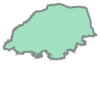

In [57]:
from shapely import wkt
wkt.loads(wkt_string)

## Construct the PAIRS query for monthly averages

### This helper function creates the json we need to pass to PAIRS
aggregations should be a list to match layers_ids specifying the aggregation type "Mean", "Sum" etc

In [58]:
def get_PAIRS_allmonths(layer_ids, aggregations, year_start, year_end, spatial):        
    layerList = list()
    il=0
    # loop over the list of PAIRS layers
    for layer_id in layer_ids:
        for month in range(1, 13):
            monthstr = str(month).zfill(2)
            for year in range(year_start, year_end + 1):        
                if(month!=12):
                    end_str = datetime(year, month+1, 1).isoformat()
                else:
                    end_str = datetime(year+1, 1, 1).isoformat()
                # query for monthly average for specific year
                # output=False as we do not return the values, only the average (see below)
                layer_year = {
                 "alias" : "val" + str(layer_id) + "_" + str(year) + monthstr, 
                 "type" : "raster", 
                 "id" : layer_id,
                 "aggregation" : aggregations[il],
                 "temporal" : { "intervals" : [{
                         "start" : datetime(year, month, 1).isoformat(),
                         "end" : end_str }]},
                 "output" : True}
                # append list
                layerList.append(layer_year)
        il+=1
    query_json = {"layers" : layerList,
                "spatial" : spatial,
                "temporal" : {"intervals" : [ {"snapshot" : datetime(year_end, month, 1).isoformat()}]}
    }
        
    return query_json

Specify the spatial extent according to the polygon loaded above

In [59]:
 spatial = {
        "type" : "poly",
        "polygon": {"wkt": wkt_string}
}

Create the query json for ERA5 temperature and CHIRPS rainfall  
We query up to end of 2018 as CHIRPS in PAIRS currently only runs to mid 2019

In [70]:
layer_ids = [pairs_dict["ERA5 temperature"], pairs_dict["CHIRPS rainfall"]]
agg = ["Mean", "Sum"]
query_json = get_PAIRS_allmonths(layer_ids, agg, 2000, 2018, spatial)
query_json2 = get_PAIRS_allmonths(layer_ids, agg, 1982, 1999, spatial)

Inspect the json - look for the layers for each month and the udf layer below  
The wkt polygon coordinates appear near the end  

In [62]:
query_json

{'layers': [{'alias': 'val49423_200001',
   'type': 'raster',
   'id': 49423,
   'aggregation': 'Mean',
   'temporal': {'intervals': [{'start': '2000-01-01T00:00:00',
      'end': '2000-02-01T00:00:00'}]},
   'output': True},
  {'alias': 'val49423_200101',
   'type': 'raster',
   'id': 49423,
   'aggregation': 'Mean',
   'temporal': {'intervals': [{'start': '2001-01-01T00:00:00',
      'end': '2001-02-01T00:00:00'}]},
   'output': True},
  {'alias': 'val49423_200201',
   'type': 'raster',
   'id': 49423,
   'aggregation': 'Mean',
   'temporal': {'intervals': [{'start': '2002-01-01T00:00:00',
      'end': '2002-02-01T00:00:00'}]},
   'output': True},
  {'alias': 'val49423_200301',
   'type': 'raster',
   'id': 49423,
   'aggregation': 'Mean',
   'temporal': {'intervals': [{'start': '2003-01-01T00:00:00',
      'end': '2003-02-01T00:00:00'}]},
   'output': True},
  {'alias': 'val49423_200401',
   'type': 'raster',
   'id': 49423,
   'aggregation': 'Mean',
   'temporal': {'intervals': [{'

Submit the query to PAIRS

In [63]:
query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH, authType='api-key') 
query.submit()

Wait until query is complete
Once the query has succeeded, we can download the layers

In [68]:
query.poll()
query.queryStatus.json()

{'id': '1618329600_12780542',
 'status': 'Succeeded',
 'start': 1618342380542,
 'folder': '1618342380513',
 'swLat': -25.422791,
 'swLon': 26.407539,
 'neLat': -22.125031,
 'neLon': 31.883829,
 'exPercent': 0.0,
 'flag': False,
 'hadoopId': '1602345287025_2174168',
 'ready': True,
 'rtStatus': 'Succeeded',
 'statusCode': 20}

In [71]:
query2 = paw.PAIRSQuery(query_json2, PAIRS_SERVER,  auth=OAUTH, authType='api-key') 
query2.submit()

In [74]:
query2.poll()
query2.queryStatus.json()

{'id': '1618329600_13734863',
 'status': 'Succeeded',
 'start': 1618343334863,
 'folder': '1618343334839',
 'swLat': -25.422791,
 'swLon': 26.407539,
 'neLat': -22.125031,
 'neLon': 31.883829,
 'exPercent': 0.0,
 'flag': False,
 'hadoopId': '1602345287025_2174684',
 'ready': True,
 'rtStatus': 'Succeeded',
 'statusCode': 20}

In [38]:
# query2 = paw.PAIRSQuery(jso, PAIRS_SERVER,  auth=OAUTH, authType='api-key') 
# query_id = '1618113600_32336463'
# query2.MockSubmitResponse(query_id)

In [75]:
# query.poll_till_finished()
# query.queryStatus.json()
query.download()
query.create_layers()

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

In [76]:
query2.download()
query2.create_layers()

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module t

# Plot the climate data 

## Helper functions to get data from queries returned by PAIRS

In [125]:
def get_clim_layer_id(pairs_layer, metadatas, month, year):
    i=0
    for metadata in metadatas:
        layer_ids = list(pd.DataFrame(metadata).transpose().index)
        match_id = [x for x in layer_ids if 'val' + str(pairs_layer) + "_" + str(year) + str(month).zfill(2) in x]
        if len(match_id) >0:
            ret = match_id[0]
            break
        i+=1
    return match_id, i

def get_clim_layer(querys, pairs_layer, month, year):
    layer_id, iq = get_clim_layer_id(pairs_layer, [query.metadata for query in querys], month, year)
    ret = querys[iq].data[layer_id]
    return ret
    
def get_meta_data(querys, pairs_layer, month, year):
    layer_id = get_clim_layer_id(pairs_layer, [query.metadata for query in querys], month, year)
    for query in querys:
        if query.data[layer_id] is not None:
            ret = query.metadata[layer_id]
    return ret
    
def get_clim_range(querys, pairs_layer, years):
    retmax = -999999.9
    retmin = 9999999.9
    for month in range(1, 13):
        for year in years:
            print(year)
            arr = get_clim_layer(querys, pairs_layer, month, year)
            minval = np.nanmin(arr)
            maxval = np.nanmax(arr)
            if minval < retmin:
                retmin = minval
            if maxval > retmax:
                retmax = maxval
    return retmin, retmax

## Generate plots for a specific month

Inspect the layer names returned by PAIRS. Each layer is the average for one month, for one PAIRS layer (i.e. variable)

Create a panel plot for temperature

In [118]:
layer_str = 'ERA5 temperature'
layer_id = pairs_dict[layer_str]
year=1989
month=12
#get_clim_layer_id(layer_id, [query.metadata, query2.metadata], 3, 1983)
layer_ids=[]
metadata = query2.metadata
layer_ids = layer_ids + list(pd.DataFrame(metadata).transpose().index)
print('val' + str(pairs_dict[layer_str]) + "_" + str(year) + str(month).zfill(2))
match_id = [x for x in layer_ids if 'val' + str(pairs_dict[layer_str]) + "_" + str(year) + str(month).zfill(2) in x]
match_id

val49423_198912


['Global weather (ERA5)-Temperature[val49423_198912]-Mean']

<ipython-input-126-3aade76a7a4b>:7: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))


1990


TypeError: unhashable type: 'list'

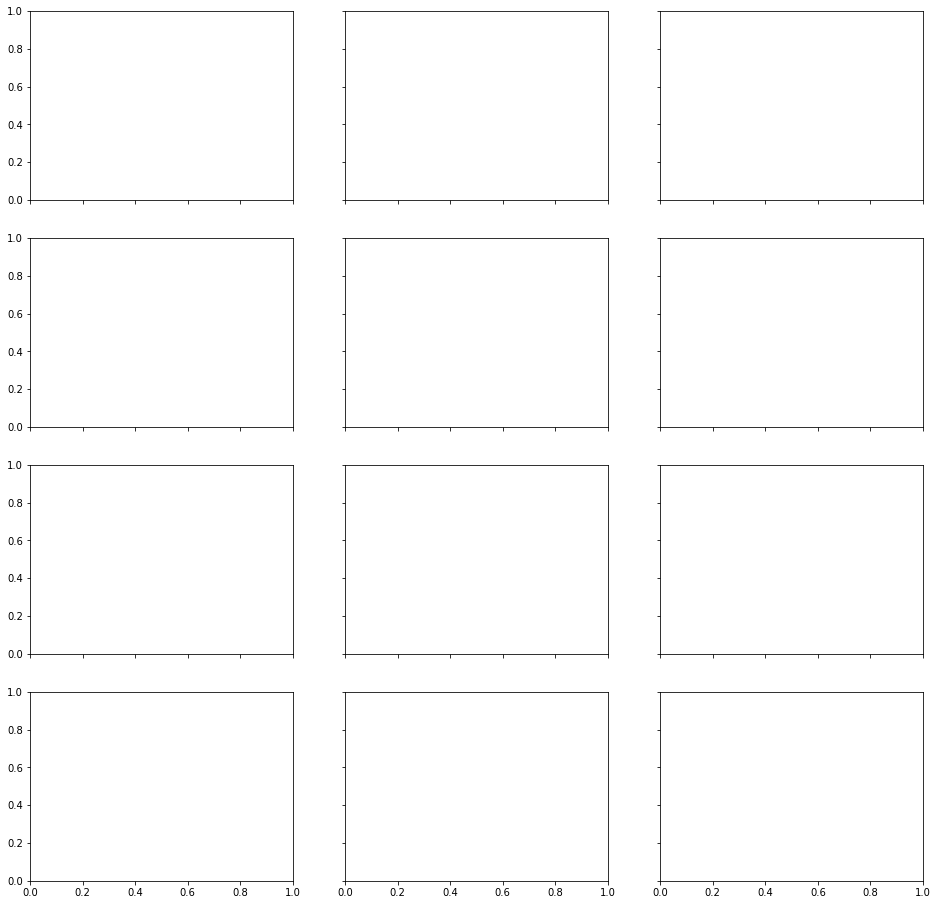

In [126]:
id_string = pd.DataFrame(query.metadata).transpose().index[0]
bbox = query.metadata[id_string]['details']['boundingBox']
extent = [bbox['minLongitude'], bbox['maxLongitude'], bbox['minLatitude'], bbox['maxLatitude']]
year=1990
layer_str = 'ERA5 temperature'
layer_id = pairs_dict[layer_str]
fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))
monthnames=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
           'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ix=0
iy=0
vmin, vmax = get_clim_range([query, query2], layer_id, range(1990, 2019))
vmin-=273.15
vmax-=273.15
print(vmin, vmax)
for i in range(12):
    data_plot = get_clim_layer([query, query2], layer_id, i+1, year)
    data_plot = data_plot - 273.15
    plot = axs[ix, iy].imshow(data_plot, extent=extent, cmap="bwr", vmin=vmin, vmax=vmax)
    axs[ix,iy].set_title(str(year)+ ': Mean ' + layer_str + ' for ' + monthnames[i])
    fig.colorbar(plot, ax=axs[ix,iy])
    i+=1
    iy+=1
    if iy>2:
        ix+=1
        iy=0
plt.show()

Create a panel plot for rainfall

<ipython-input-44-fd6aef4a9082>:7: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))


0.0 11.06104564666748


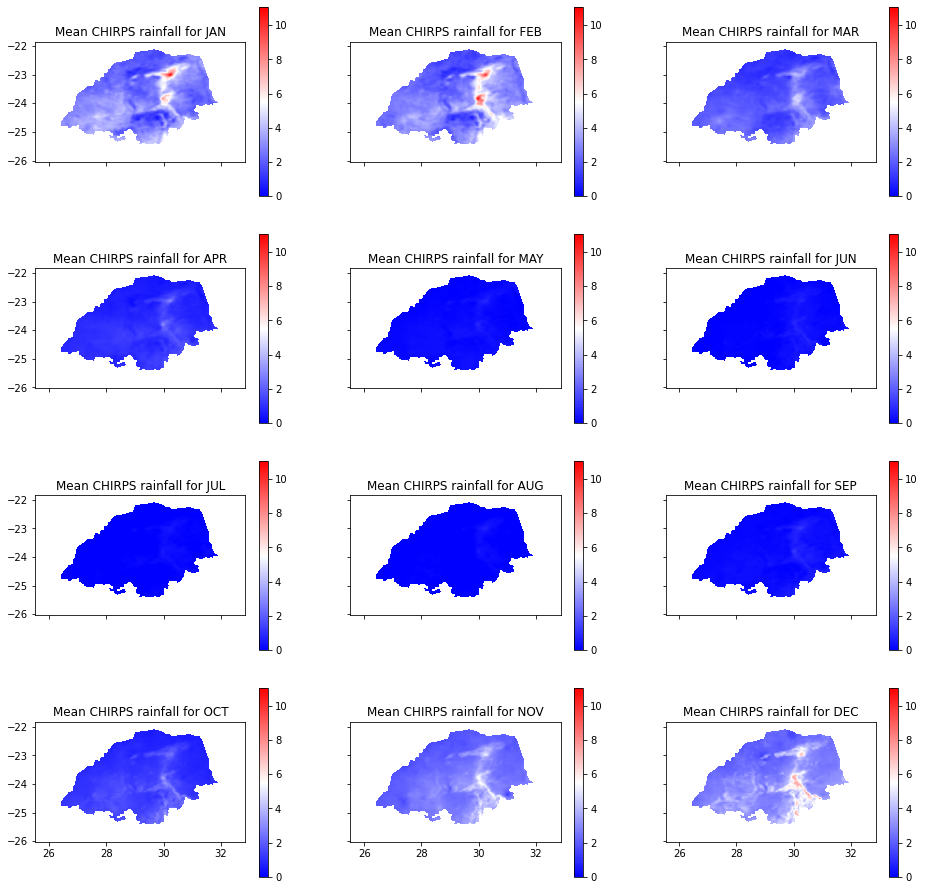

In [44]:
id_string = pd.DataFrame(query.metadata).transpose().index[0]
bbox = query.metadata[id_string]['details']['boundingBox']
extent = [bbox['minLongitude'], bbox['maxLongitude'], bbox['minLatitude'], bbox['maxLatitude']]

layer_str = 'CHIRPS rainfall'
layer_id = pairs_dict[layer_str]
fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))
monthnames=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
           'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ix=0
iy=0
vmin, vmax = get_clim_range(query, layer_id)
print(vmin, vmax)
for i in range(12):
    data_plot = get_clim_layer(query, layer_id, i+1)
    plot = axs[ix, iy].imshow(data_plot, extent=extent, cmap="bwr", vmin=vmin, vmax=vmax)
    axs[ix,iy].set_title('Mean ' + layer_str + ' for ' + monthnames[i])
    fig.colorbar(plot, ax=axs[ix,iy])
    i+=1
    iy+=1
    if iy>2:
        ix+=1
        iy=0
plt.show()

# Save the PAIRS query output to use in PART 2

### Watson Studio version

In [33]:
layer_str = 'CHIRPS rainfall'
layer_id = pairs_dict[layer_str]
for i in range(12):
    data = get_clim_layer(query, layer_id, i+1)
    project.save_data(file_name = layer_str + "_" + str(i).zfill(2) + ".csv", data = pd.DataFrame(data).to_csv(header=None, index=None))

In [34]:
layer_str = 'ERA5 temperature'
layer_id = pairs_dict[layer_str]
for i in range(12):
    data = get_clim_layer(query, layer_id, i+1)
    project.save_data(file_name = layer_str + "_" + str(i).zfill(2) + ".csv", data = pd.DataFrame(data).to_csv(header=None, index=None))

In [50]:
metadata = get_meta_data(query, layer_id, 2)
metadata

{'datalayerId': '0',
 'datalayerName': 'avg_4931602',
 'datalayerAlias': 'avg_4931602',
 'temporalAggregation': 'Exp',
 'layerType': 'raster',
 'details': {'pixelType': 'fl',
  'pixelNoDataVal': -9999.0,
  'spatialRef': 'EPSG:4326',
  'boundingBox': {'minLatitude': -26.036864,
   'maxLatitude': -21.84256,
   'minLongitude': 25.520896,
   'maxLongitude': 32.860928},
  'pixelDimensions': {'pixelSizeDegreeLongitude': 0.032768,
   'pixelSizeDegreeLatitude': 0.032768,
   'numberPixelsLatitude': 128,
   'numberPixelsLongitude': 224},
  'rasterStatistics': {'pixelMin': 0.514647,
   'pixelMax': 10.732076,
   'pixelCount': 10751,
   'pixelMean': 2.943307,
   'pixelStandardDeviation': 1.124759}}}

### Local version

In [74]:
layer_str = 'CHIRPS rainfall'
layer_id = pairs_dict[layer_str]
for i in range(12):
    data = get_clim_layer(query, layer_id, i+1)
    file_name = datadir + 'data' + '_' + layer_str + "_" + str(i).zfill(2) + '.csv'
    pd.DataFrame(data).to_csv(file_name, header=None, index=None)
    file_name = datadir + 'metadata' + "_" + layer_str + "_" + str(i).zfill(2) + '.txt'
    metadata = get_meta_data(query, layer_id, i+1)
    with open(file_name, 'w') as file:
        json.dump(metadata['details'], file)

In [76]:
layer_str = 'ERA5 temperature'
layer_id = pairs_dict[layer_str]
for i in range(12):
    data = get_clim_layer(query, layer_id, i+1)
    file_name = datadir + 'data' + '_' + layer_str + "_" + str(i).zfill(2) + '.csv'
    pd.DataFrame(data).to_csv(file_name, header=None, index=None)
    file_name = datadir + 'metadata' + "_" + layer_str + "_" + str(i).zfill(2) + '.txt'
    metadata = get_meta_data(query, layer_id, i+1)
    with open(file_name, 'w') as file:
        json.dump(metadata['details'], file)

In [78]:
layer_str = 'CHIRPS rainfall'
layer_id = pairs_dict[layer_str]
i=1
data = get_clim_layer(query, layer_id, i+1)
data.shape

(128, 224)